In [30]:
import requests
import osmnx as ox
import networkx as nx
import geopandas as gpd
import numpy as np
import pandas as pd

                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((301997.266 -4082816.606, 302016.825 ...  -36.867678  -36.870725   

    bbox_east   bbox_west   place_id osm_type    osm_id        lat  \
0  174.779537  174.778569  118523389      way  48383821 -36.869262   

          lon                                       display_name    class  \
0  174.778972  Newmarket, Joseph Banks Terrace, Newmarket, Au...  railway   

      type  importance  
0  station    0.460255  


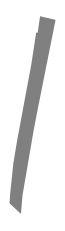

In [31]:
# Find Auckland location from osmx package
city = ox.geocode_to_gdf("NewMarket, Auckland, NZ")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
_ = ax.axis("off")
print(city_proj)

In [32]:
gdf = ox.geometries.geometries_from_point((-36.8679152, 174.7774390),tags={'amenity':True,'shop':True},dist=1000)
gdf.drop(['addr:housenumber', 'addr:street',
          'phone','website',
          'wheelchair','addr:city',
          'payment:coins','brand',
          'brand:wikidata',
          'brand:wikipedia',
          'cuisine',
          'operator','operator:wikidata','operator:wikipedia',
          'addr:postcode','opening_hours','opening_hours','addr:suburb','email','internet_access',
          'ref:linz:address_id','second_hand','access','fee','bicycle_parking','capacity','covered','nodes',
          'height','supervised','building:levels','layer','operator:type','payment:app','payment:credit_cards'
         ], axis=1, inplace=True)
projected_gdf = ox.project_gdf(gdf)

poi_node_df_columns = ['amenity', 'name', 'geometry',  'shop', 'takeaway',
       'healthcare', 'parking', 'clothes', 'building']
poi_node_df = pd.DataFrame(columns=poi_node_df_columns)

for df_index in projected_gdf.index.values:
    index_type = df_index[0]
    osm_node_id = df_index[1]
    if index_type=="way":
        continue
    row = projected_gdf.loc[df_index]
    poi_node_df = pd.concat([poi_node_df,pd.DataFrame([row],
                                            columns=poi_node_df_columns,
                                            index=[osm_node_id])])
projected_poi_node_df = gpd.geodataframe.DataFrame(poi_node_df)
print(projected_poi_node_df.head())

            amenity                    name  \
65389942     cinema        Rialto Newmarket   
65390974        pub            The Claddagh   
260727342    cinema  Event Cinemas Broadway   
294042724   library         Parnell Library   
319637290  post_box                     NaN   

                                                 geometry shop takeaway  \
65389942     POINT (301905.0549123612 -4082575.175754066)  NaN      NaN   
65390974      POINT (301888.0684892599 -4083005.15327504)  NaN      NaN   
260727342   POINT (301964.5569961929 -4082333.7106822957)  NaN      NaN   
294042724  POINT (302110.94370448345 -4082007.7972311485)  NaN      NaN   
319637290  POINT (301267.37850666884 -4082369.3604571316)  NaN      NaN   

          healthcare parking clothes building  
65389942         NaN     NaN     NaN      NaN  
65390974         NaN     NaN     NaN      NaN  
260727342        NaN     NaN     NaN      NaN  
294042724        NaN     NaN     NaN      NaN  
319637290        NaN     N

In [33]:
highway_G = ox.graph_from_point(
    (-36.8679152, 174.7774390),
    dist=1000,
    dist_type="network",
    network_type="walk",
    simplify=False,
    retain_all=True,
    custom_filter = '["highway"~"unclassified|trunk|primary|tertiary|secondary|track|path|residential"]'
)
projected_highway_G = ox.project_graph(highway_G)
print(projected_highway_G)

MultiDiGraph with 1031 nodes and 2160 edges


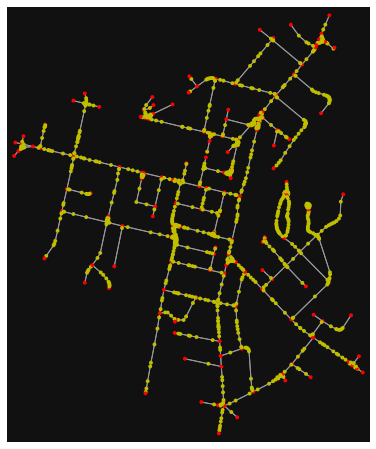

In [34]:
# turn off strict mode and see what nodes we'd remove, in yellow
nc = ["r" if ox.simplification._is_endpoint(projected_highway_G, node) else "y" for node in projected_highway_G.nodes()]
fig, ax = ox.plot_graph(projected_highway_G, node_color=nc)

In [59]:
from shapely.geometry import Polygon,MultiPolygon


# 给POI node找到最近的路段，取出该POI node的Amenity类型 或者shop 类型
# 把node id，poi类型，边的node pair 存进一个DF
def find_edge_for_node(road_G,poi_df):
    columns = ["source","target","distance_to_edge",'amenity', 'name', 'geometry', 'shop', 'takeaway',
       'healthcare', 'parking', 'clothes', 'building']
    output_df = pd.DataFrame(columns=columns)
    road_nodes = road_G.nodes(data=True)

    for row in poi_df.iterrows():
        node_id, node_detail = row[0], row[1]
        coord = node_detail["geometry"]
        if type(coord) == Polygon or type(coord) == MultiPolygon:
            coord = coord.centroid.xy
            x,y= coord[0][0],coord[1][0]
        else:
            x,y =  coord.x,coord.y
        # 找出poi和 路段起始 或者 路段末端 的距离
        #print(coord)
        u,v,_= ox.distance.nearest_edges(road_G, x,y,return_dist=False)

        #print("coord ",coord.y,coord.x)
        #print("start ",road_nodes[u]["y"],road_nodes[u]["x"])
        #print("end ",road_nodes[v]["y"],road_nodes[v]["x"])
        distance_to_road_start = ox.distance.euclidean_dist_vec(y,x,
                                                              road_nodes[u]["y"],road_nodes[u]["x"])
        distance_to_road_end = ox.distance.euclidean_dist_vec(y,x,
                                                            road_nodes[v]["y"],road_nodes[v]["x"])
        average_distance_to_poi = (distance_to_road_start+ distance_to_road_end)/2

        #print(distance_to_road_start,distance_to_road_end,average_distance_to_poi)
        mapping_row = [u,v,average_distance_to_poi]
        mapping_row= mapping_row+list(node_detail.to_dict().values())
        output_df = pd.concat([output_df,pd.DataFrame([mapping_row],
                                            columns=columns,
                                            index=[node_id])])
    return output_df

In [58]:
poi_mapping_df = find_edge_for_node(projected_highway_G,projected_poi_node_df)
#poi_mapping_df.to_csv("./NewMarket_POI_Edges")
print(poi_mapping_df.head())

POINT (301905.0549123612 -4082575.175754066)
POINT (301888.0684892599 -4083005.15327504)
POINT (301964.5569961929 -4082333.7106822957)
POINT (302110.94370448345 -4082007.7972311485)
POINT (301267.37850666884 -4082369.3604571316)
POINT (301958.289120601 -4082436.5338237127)
POINT (301552.20215938723 -4081610.943162389)
POINT (302342.5159383369 -4081534.7797144684)
POINT (301294.33217911876 -4082051.4612695617)
POINT (301194.4514816567 -4083152.6774278427)
POINT (301875.49754221376 -4082676.010244153)
POINT (302382.52874608606 -4083139.091816047)
POINT (302203.6333231759 -4081937.1686742394)
POINT (301956.9370181684 -4082815.2690079776)
POINT (301917.8553212299 -4082496.66800483)
POINT (301928.9670021005 -4082578.5600362453)
POINT (301960.2213321201 -4082519.9273124496)
POINT (302072.4355902469 -4082130.919564552)
POINT (302280.7243042254 -4081874.286078122)
POINT (302015.0063793674 -4081746.6807197644)
POINT (300994.8862523064 -4081748.5269650305)
POINT (301881.6777207409 -4083429.62234

In [69]:
#把street转成了node，并且加入了周围POI的type当作feature
def construct_street_nodes(highway_graph,poi_mapping_df):
    columns = ["source","target",'street_name','street_length']
    street_node_output_df = pd.DataFrame(columns=columns)

    for edge in highway_graph.edges(data=True):
        u,v,data = edge
        if data['reversed'] or "name" not in data.keys():
            continue
        print(data)
        street_id,street_name,street_length = data["osmid"],data["name"],\
                                                       data["length"]
        mapping_row = [u,v,street_name,street_length]
        current_street_node_df = pd.DataFrame([mapping_row],
                                              columns=columns,
                                              index=[street_id])
        #print(u,v)
        matched_source = poi_mapping_df[poi_mapping_df["source"]==u]
        matched_poi_df = matched_source[matched_source["target"]==v]
        # drop unneed columns
        #matched_poi_df= matched_poi_df.drop(labels=["source","target","name"],axis=1)

        number_of_pois = len(matched_poi_df)
        poi_to_edge_total_distance = 0.0
        # Go through poi_df and added up the poi on edge node
        for poi_data in matched_poi_df.iterrows():
            for key,value in poi_data[1].to_dict().items():
                # if key in ["source","target","name"]:
                #     print(street_name,key,value)
                # 把POI到节点的距离先加起来
                if key == "distance_to_edge":
                    poi_to_edge_total_distance += value
                    #print("dist" ,value)
                    continue
                if value is None or str(value)=="nan" or key == "geometry" or key in ["source","target","name"]:
                    continue
                if (key+":"+value) not in current_street_node_df.columns:
                    current_street_node_df[key+":"+value] =0
                current_street_node_df[key+":"+value] +=1
        # 获得POI到街的平均距离
        if number_of_pois > 0:
            poi_to_edge_average_distance = poi_to_edge_total_distance / number_of_pois
            current_street_node_df["Average_POI_Distance"] = poi_to_edge_average_distance
        street_node_output_df = pd.concat([street_node_output_df,current_street_node_df])
    return street_node_output_df

In [70]:
street_node_df=construct_street_nodes(projected_highway_G,poi_mapping_df)
#print(street_node_df.sort_values("street_name")["street_length"])
#print(street_node_df.sort_values("street_name")["Average_POI_Distance"])
print(street_node_df)

{'osmid': 617488811, 'lanes': '3', 'name': 'Park Road', 'highway': 'secondary', 'maxspeed': '50', 'oneway': False, 'reversed': False, 'length': 7.054}
{'osmid': 670451443, 'name': 'Carlton Gore Road', 'highway': 'unclassified', 'maxspeed': '50', 'oneway': False, 'reversed': False, 'length': 9.166}
{'osmid': 55207939, 'lanes': '3', 'name': 'Park Road', 'highway': 'secondary', 'maxspeed': '50', 'oneway': False, 'reversed': False, 'length': 4.249}
{'osmid': 617488805, 'lanes': '3', 'name': 'Carlton Gore Road', 'highway': 'secondary', 'maxspeed': '50', 'oneway': False, 'reversed': False, 'length': 12.421}
{'osmid': 617488811, 'lanes': '3', 'name': 'Park Road', 'highway': 'secondary', 'maxspeed': '50', 'oneway': False, 'reversed': False, 'length': 0.755}
{'osmid': 670451443, 'name': 'Carlton Gore Road', 'highway': 'unclassified', 'maxspeed': '50', 'oneway': False, 'reversed': False, 'length': 43.919}
{'osmid': 163683237, 'lanes': '5', 'name': 'Khyber Pass Road', 'highway': 'primary', 'maxsp

In [71]:
def construct_street_edges(nodes_df):
    edge_dict = {}
    for data in nodes_df.iterrows():
        street_index,node = data[0],data[1]
        u,v = node['source'],node['target']
        #print(u,v)
        same_source_neighbours_df = nodes_df[nodes_df["source"]==u]
        same_source_neighbours_df = same_source_neighbours_df[same_source_neighbours_df["target"]!=v]

        same_target_neighbours_df = nodes_df[nodes_df["target"]==v]
        same_target_neighbours_df = same_target_neighbours_df[same_target_neighbours_df["source"]!=u]
        # Loop through neighbours with same source
        for neighbour_data in same_source_neighbours_df.iterrows():
            neighbour_index,neighbour = neighbour_data[0],neighbour_data[1]
            # nodes within same street can not have same source or target
            edge_key = (street_index,neighbour_index)
            edge_distance =  node['street_length'] + neighbour['street_length']

            if edge_key in edge_dict and edge_dict[edge_key]!=edge_distance:
                raise Exception("Multiple Edge Distances with same source")

            edge_dict[(street_index,neighbour_index)] = edge_distance

        # Loop through neighbours with same target
        for neighbour_data in same_target_neighbours_df.iterrows():
            neighbour_index,neighbour = neighbour_data[0],neighbour_data[1]
            # nodes within same street can not have same source or target
            edge_key = (street_index,neighbour_index)
            reverse_edge_key=(neighbour_index,street_index)
            edge_distance =  node['street_length'] + neighbour['street_length']

            if edge_key in edge_dict and edge_dict[edge_key]!=edge_distance:
                raise Exception("Multiple Edge Distances with same source")

            if reverse_edge_key in edge_dict:
                continue

            edge_dict[(street_index,neighbour_index)] = edge_distance
        #print(edge_dict)
        #break
    return edge_dict

In [72]:
edge_dict = construct_street_edges(street_node_df)
edge_df = pd.DataFrame(columns=["source_street","target_street","distance"])
for k,v in edge_dict.items():
    row = pd.DataFrame([[k[0],k[1],v]],columns=["source_street","target_street","distance"])
    #print(row)
    edge_df = pd.concat([edge_df,row])
print(edge_df)

   source_street target_street  distance
0      617488811     670451443    16.220
0      670451443     617488811    16.220
0       55207939     617488805    16.670
0        4309719     617488778    36.297
0        4309719     628130498    19.785
..           ...           ...       ...
0      902210355    1021310055     9.913
0     1021310055     902210355     9.913
0     1021310055    1021310052    10.786
0      902210355    1021310066    11.415
0       28771828    1024092419     9.641

[219 rows x 3 columns]
